In [247]:
import pandas as pd
import numpy as np
from random import randint, choice

import matplotlib.pyplot as plt

## Classes

In [766]:
class Dice:
    def __init__(self, number, size):
        self.num = number
        self.size = size
        
    def roll(self):
        return sum([randint(1, self.size) for x in range(self.num)])
    
d20 = Dice(1,20)
    
class Character:
    def __init__(self, HP, AC, attack_mod, damage_die, damage_mod):
        self.atk = attack_mod
        self.die = damage_die
        self.dmg = damage_mod
        self.hp_total = HP
        self.hp_current = HP
        self.ac = AC
        
        self.dmg_die = Dice(int(damage_die.split("d")[0]),
                            int(damage_die.split("d")[1]))
        
    def check(self, Char):
        return randint(1,20) > Char.ac
    
    def damage(self, hit):
        self.hp_current = self.hp_current - hit
    
    def attack(self, Char):
        damage_output = self.dmg_die.roll()+self.dmg
        if self.check(Char):
            Char.damage(damage_output)
        return damage_output, damage_output>0
            
    def is_alive(self):
        return self.hp_current > 0
    
    def reset(self):
        self.hp_current = self.hp_total

    
class Party:
    def __init__(self, char_list):
        self.char_list = char_list
        
    def get_alive(self):
        return [x for x in self.char_list if x.is_alive()]
        
    def choose_alive(self):
        return choice(self.get_alive())
    
    def attack(self, Pty):
        damage_output = 0
        checks = 0
        for c in self.get_alive():
            if Pty.is_alive():
                d_o, check = c.attack(Pty.choose_alive())
                damage_output = damage_output + d_o
                checks = checks + check
        return damage_output, checks
    
    def num_alive(self):
        return len(self.get_alive())
    
    def is_alive(self):
        return self.num_alive() > 0
    
    def get_hp(self):
        return [x.hp_current for x in self.char_list]
    
    def reset(self):
        for c in self.char_list:
            c.reset()
        

class Turn:
    def __init__(self, pj_party, enemy_party, pj_init):
        self.pjs = pj_party
        self.enemies = enemy_party
        self.pj_init = pj_init
        self.damage_done = 0
        self.atk_success = 0
        
    def is_alive(self):
        return self.pjs.is_alive() and self.enemies.is_alive()
    
    def run(self):
        self.damage_done = 0
        self.atk_success = 0
        
        char_list = [self.pjs, self.enemies]
        
        if self.is_alive():
            for w in [self.pj_init, 1-self.pj_init]:
                d_o, check = char_list[w].attack(char_list[1-w])
                self.damage_done = self.damage_done + d_o
                self.atk_success = self.atk_success + check
                
    def status(self):
        print("PJ alive:", self.pjs.num_alive())
        print("Enemies alive:", self.enemies.num_alive())
        print('\n')
        print('Current player HP')
        for c in self.pjs.char_list:
            print(f'{c.hp_current}/{c.hp_total}')
            
            
class Encounter:
    def __init__(self, pj_party, enemy_party):
        self.pjs = pj_party
        self.enemies = enemy_party
        self.turn = Turn(self.pjs, self.enemies, randint(0,1))
        
        self.party_hp = np.array(pj_party.get_hp()).reshape(
            (1, len(pj_party.get_hp())))
        self.enemies_alive = [self.enemies.num_alive()]
        self.pjs_alive = [self.pjs.num_alive()]
        self.damage_output = [0]
        self.atk_success = [0]
        
        self.num_turns = 0
        
    def run(self):
        while self.turn.is_alive():
            self.turn.run()
            self.party_hp = np.concatenate([
                self.party_hp,
                np.array(self.turn.pjs.get_hp()).reshape(
                    (1, len(self.pjs.get_hp())))],
                axis=0)
            self.num_turns = self.num_turns + 1
            self.enemies_alive.append(self.enemies.num_alive())
            self.pjs_alive.append(self.pjs.num_alive())
            self.damage_output.append(self.turn.damage_done)
            self.atk_success.append(self.turn.atk_success)

    def status(self):
        return {
            'pjs_alive': self.pjs_alive[-1],
            'enemies_alive': self.enemies_alive[-1],
            'damage_output': self.damage_output[-1],
            'num_turns': self.num_turns,
            'atk_success': self.atk_success[-1],
            'party_hp': ','.join([str(x) for x in self.party_hp[-1,:]]),
            'pj_initiative': self.turn.pj_init
        }
    
    def get_hp_df(self):
        hp_df = pd.DataFrame(self.party_hp / 
                             [x.hp_total for x in self.pjs.char_list],
                     columns=[f'pj{i}' for i in range(self.party_hp.shape[1])])
        hp_df['enemies_alive'] = (np.array(self.enemies_alive) / 
            max(self.enemies_alive))
        return hp_df
    
    def hp_plot(self):
        hp_df = self.get_hp_df()
        hp_df.plot()
        plt.plot([0,self.num_turns], [0,0], linestyle='--')
        
    def reset(self):
        self.pjs.reset()
        self.enemies.reset()
        self.party_hp = np.array(self.pjs.get_hp()).reshape(
            (1, len(self.pjs.get_hp())))
        self.enemies_alive = [self.enemies.num_alive()]
        self.pjs_alive = [self.pjs.num_alive()]
        self.damage_output = [0]
        self.atk_success = [0]
        self.num_turns = 0
        self.turn = Turn(self.pjs, self.enemies, randint(0,1))

In [767]:
np.array([10, 11]).reshape((1,2))

array([[10, 11]])

## Enemies

In [768]:
def Goblin():
    return Character(10, 13, 3, "1d4", 2)

In [769]:
enemies = Party([Goblin() for x in range(10)])

## Players

In [770]:
pala = Character(20, 18, 4, "1d6", 3)
rogue = Character(15, 15, 4, "1d8", 3)
barbarian = Character(17, 16, 4, "1d12", 4)

In [771]:
party = Party([pala, rogue, barbarian])

## Encounter

In [772]:
enc = Encounter(party, enemies)

In [773]:
enc.run()

In [774]:
max(enc.enemies_alive)

10

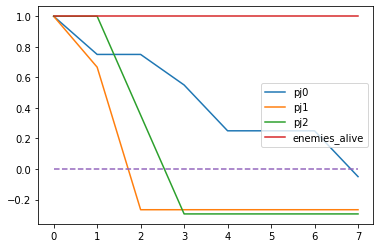

In [775]:
enc.hp_plot()
enc.reset()

## HP Simulation

In [874]:
def Goblin():
    return Character(10, 12, 4, "1d4", 0)

In [881]:
# enemies
enemies = Party([Goblin() for x in range(3)]+[Character(20,15,5,'2d4',1)])

# party
pala = Character(18, 18, 3, "1d6", 2)
rogue = Character(14, 15, 2, "1d6", 3)
barbarian = Character(16, 16, 4, "1d8", 3)

party = Party([pala, rogue, barbarian])

# encounter
enc = Encounter(party, enemies)

# simulation dataframe
df_sim = pd.DataFrame()
df_total = pd.DataFrame()

for i in range(1000):
    enc.run()
    df = enc.get_hp_df()
    df_total = df_total.append(df.assign(num_sim=i),ignore_index=True)
    df_sim = df_sim.append(enc.status(),ignore_index=True)
    enc.reset()

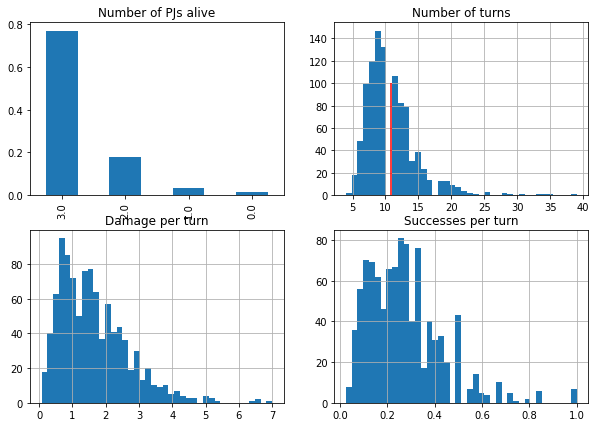

In [882]:
plt.rcParams['figure.figsize'] = (10,7)

plt.subplot(221)
df_sim.pjs_alive.value_counts(normalize=True).plot.bar()
plt.title('Number of PJs alive')

plt.subplot(222)
df_sim.num_turns.hist(bins=40)
plt.vlines(x=df_sim.num_turns.mean(), ymin=0, ymax=100, color='r')
plt.title('Number of turns')

plt.subplot(223)
(
    df_sim
    .assign(dmg_turn=lambda x: x.damage_output/x.num_turns)
    .dmg_turn
    .hist(bins=40)
)
plt.title('Damage per turn')

plt.subplot(224)
(
    df_sim
    .assign(succ_turn=lambda x: x.atk_success/x.num_turns)
    .succ_turn
    .hist(bins=40)
)
plt.title('Successes per turn')

plt.show()

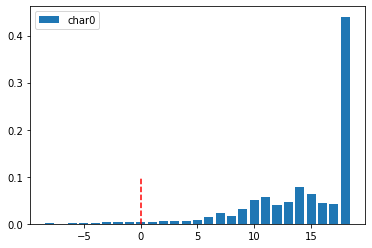

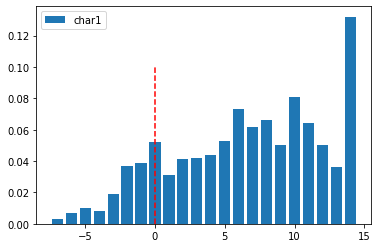

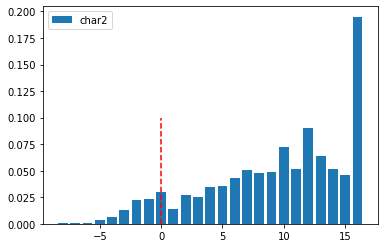

In [883]:
plt.rcParams['figure.figsize'] = (6,4)
df_hist = (
    df_sim
    .party_hp
    .str.split(',',expand=True)
    .rename(lambda x:f'char{x}', axis='columns')
    .astype(int)
)

for c in df_hist.columns:
    counts = df_hist[c].value_counts()
    plt.bar(counts.index, counts.values / counts.values.sum(),
           label=c)
    plt.vlines(x=0, ymin=0, ymax=0.1, linestyle='--', color='r')
    plt.legend()
    plt.show()

In [884]:
df_sim

,atk_success,damage_output,enemies_alive,num_turns,party_hp,pj_initiative,pjs_alive
0,1.0,6.0,0.0,10.0,"17,6,-3",0.0,2.0
1,3.0,17.0,0.0,13.0,"13,11,4",1.0,3.0
2,3.0,21.0,0.0,12.0,"18,2,7",0.0,3.0
3,2.0,14.0,0.0,11.0,"14,10,5",0.0,3.0
4,3.0,20.0,0.0,12.0,"12,3,2",1.0,3.0
...,...,...,...,...,...,...,...
995,3.0,18.0,0.0,7.0,"14,10,6",0.0,3.0
996,1.0,7.0,0.0,12.0,"12,0,8",0.0,2.0
997,2.0,16.0,0.0,10.0,"18,14,16",0.0,3.0
998,2.0,16.0,0.0,11.0,"15,13,14",0.0,3.0
